Symulacja dla testu Shapiro-Wilk...
Symulacja dla testu Kolmogorov-Smirnov...
Symulacja dla testu Chi2...


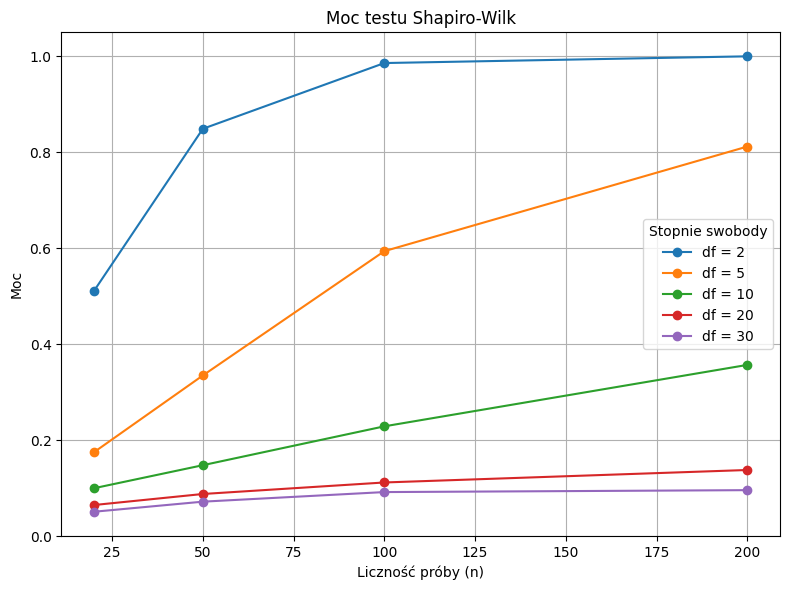

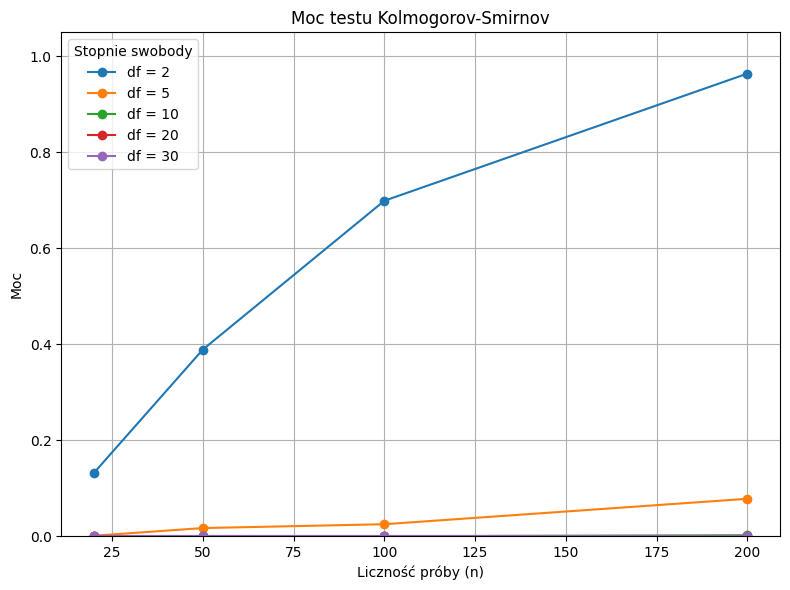

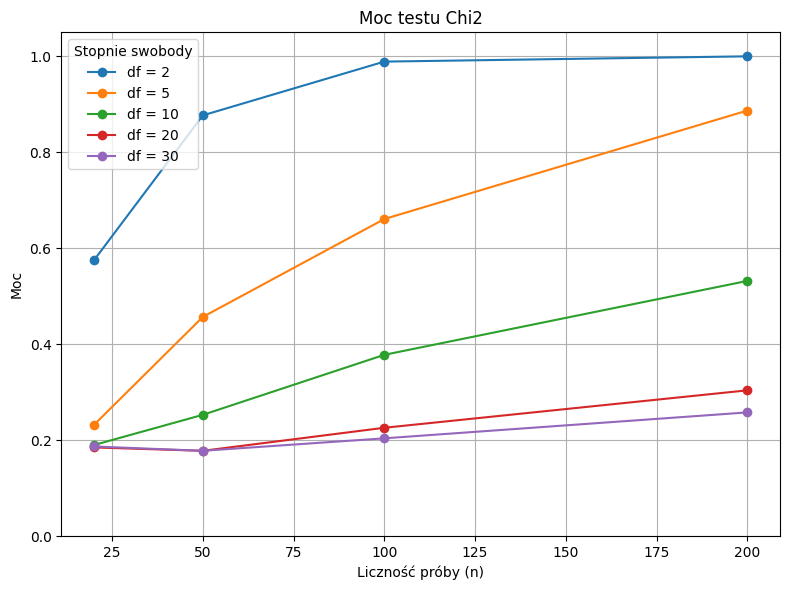

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Parametry
sample_sizes = [20, 50, 100, 200]
degrees_of_freedom = [2, 5, 10, 20, 30]
n_simulations = 1000
alpha = 0.05

# Funkcje testów
def shapiro_test(sample):
    return stats.shapiro(sample).pvalue

def ks_test(sample):
    return stats.kstest(sample, 'norm', args=(np.mean(sample), np.std(sample, ddof=1))).pvalue

def chi2_test(sample, bins='auto'):
    observed, bins = np.histogram(sample, bins=bins)
    expected = stats.norm.cdf(bins[1:], loc=np.mean(sample), scale=np.std(sample)) - stats.norm.cdf(bins[:-1], loc=np.mean(sample), scale=np.std(sample))
    expected *= len(sample)
    expected[expected < 1e-6] = 1e-6  # zabezpieczenie
    chi2_stat = ((observed - expected) ** 2 / expected).sum()
    df_chi2 = len(observed) - 1 - 2
    p_value = 1 - stats.chi2.cdf(chi2_stat, df_chi2)
    return p_value

# Obliczanie mocy dla wszystkich testów
power_results = {'Shapiro-Wilk': [], 'Kolmogorov-Smirnov': [], 'Chi2': []}

for test_name, test_func in zip(power_results.keys(), [shapiro_test, ks_test, chi2_test]):
    matrix = []
    print(f"Symulacja dla testu {test_name}...")
    for df in degrees_of_freedom:
        row = []
        for n in sample_sizes:
            rejections = 0
            for _ in range(n_simulations):
                sample = stats.t.rvs(df, size=n)
                p_value = test_func(sample)
                if p_value < alpha:
                    rejections += 1
            power = rejections / n_simulations
            row.append(power)
        matrix.append(row)
    power_results[test_name] = np.array(matrix)


# Wykresy
for test_name in power_results:
    plt.figure(figsize=(8,6))
    for i, df in enumerate(degrees_of_freedom):
        plt.plot(sample_sizes, power_results[test_name][i, :], marker='o', label=f'df = {df}')
    plt.title(f'Moc testu {test_name}')
    plt.xlabel('Liczność próby (n)')
    plt.ylabel('Moc')
    plt.ylim(0, 1.05)
    plt.legend(title='Stopnie swobody')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# WNIOSKI
# Im mniejszy df (tzn. większa „ciężkość ogona” rozkładu t-Studenta), tym większa moc wszystkich testów.
# Wraz ze wzrostem liczności próby (n) rośnie moc wszystkich testów, zwłaszcza dla małych i średnich df.
# Test Shapiro-Wilka generalnie ma największą moc dla małych i średnich df. SW osiąga szybciej wysoką moc przy mniejszych próbach w porównaniu do KS i Chi2.
# Test KS i Chi2 wypadają trochę słabiej od Shapiro-Wilka, ale nadal dobrze detektują odstępstwa od normalności, szczególnie dla df=2 i df=5.
# Dla dużych df (20-30) i małych próbek (n=20-50) wszystkie testy mają słabą moc:
# Przy df=30 i n=50 moc spada nawet do ~15%-20%.

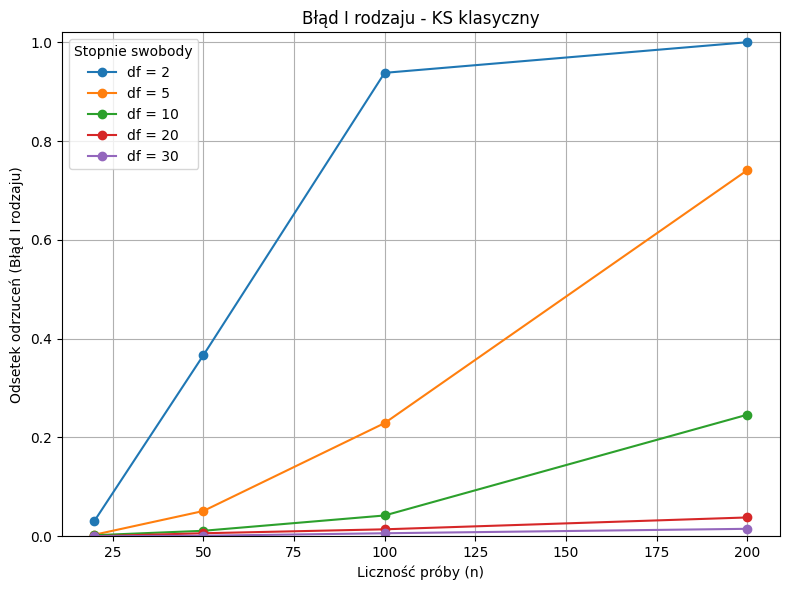

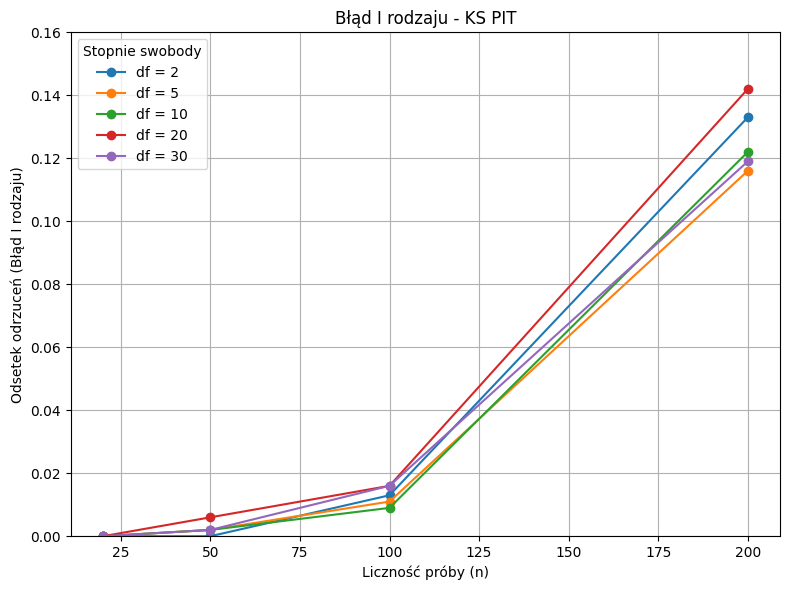

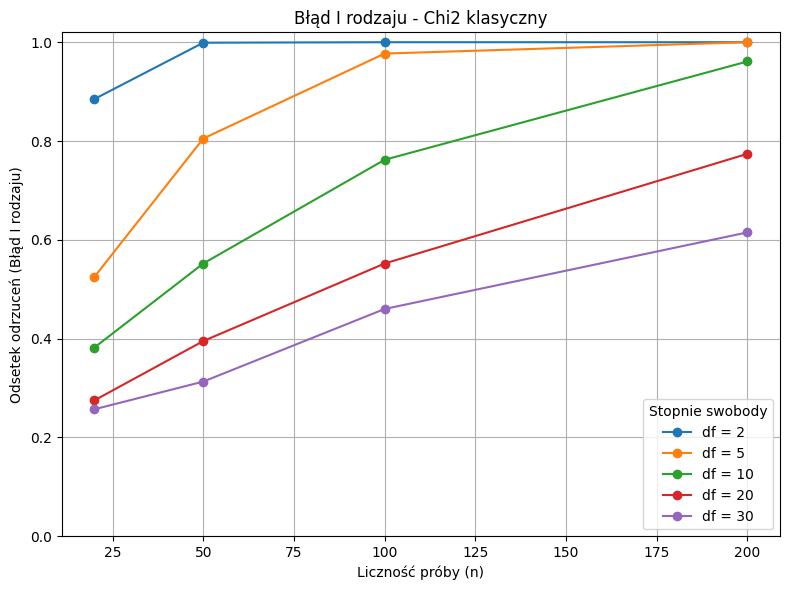

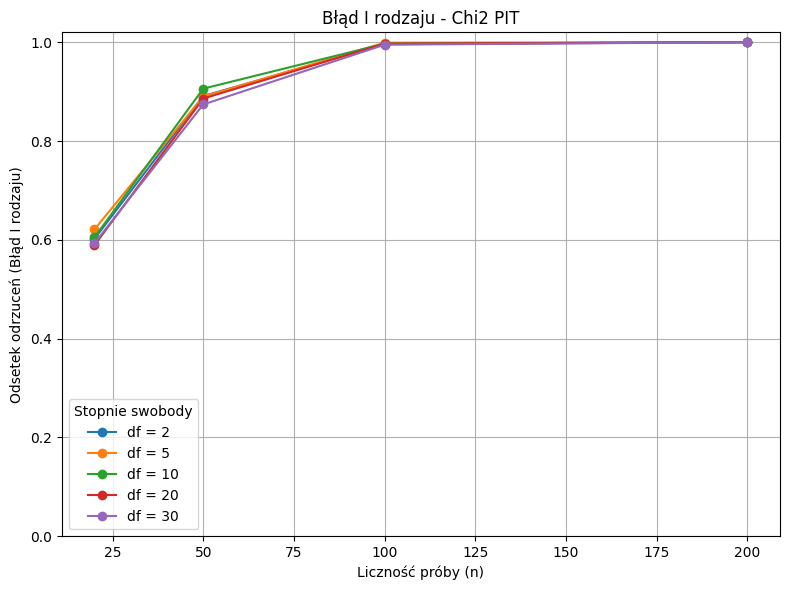

In [ ]:
# Parametry symulacji
sample_sizes = [20, 50, 100, 200]
degrees_of_freedom = [2, 5, 10, 20, 30]
n_simulations = 1000
alpha = 0.05

# Funkcje testów
def ks_test(sample):
    return stats.kstest(sample, 'norm', args=(np.mean(sample), np.std(sample, ddof=1))).pvalue

def chi2_test(sample, bins='auto'):
    observed, bins = np.histogram(sample, bins=bins)
    expected = stats.norm.cdf(bins[1:], loc=np.mean(sample), scale=np.std(sample)) - stats.norm.cdf(bins[:-1], loc=np.mean(sample), scale=np.std(sample))
    expected *= len(sample)
    expected[expected < 1e-6] = 1e-6
    chi2_stat = ((observed - expected) ** 2 / expected).sum()
    df_chi2 = len(observed) - 1 - 2
    p_value = 1 - stats.chi2.cdf(chi2_stat, df_chi2)
    return p_value

def PIT_transform(sample, df):
    return stats.chi2.cdf(sample, df=df)  # PIT transformacja


# Symulacje
results = {
    'KS klasyczny': [],
    'KS PIT': [],
    'Chi2 klasyczny': [],
    'Chi2 PIT': []
}

for test_name in results.keys():
    matrix = []
    for df_chi in degrees_of_freedom:
        row = []
        for n in sample_sizes:
            rejections = 0
            for _ in range(n_simulations):
                sample = stats.chi2.rvs(df_chi, size=n)
                if 'PIT' in test_name:
                    sample = PIT_transform(sample, df_chi)
                if 'KS' in test_name:
                    p_value = ks_test(sample)
                else:
                    p_value = chi2_test(sample)
                if p_value < alpha:
                    rejections += 1
            row.append(rejections / n_simulations)
        matrix.append(row)
    results[test_name] = np.array(matrix)


# Wykresy
for test_name in results:
    plt.figure(figsize=(8,6))
    for i, df_chi in enumerate(degrees_of_freedom):
        plt.plot(sample_sizes, results[test_name][i, :], marker='o', label=f'df = {df_chi}')
    plt.title(f'Błąd I rodzaju - {test_name}')
    plt.xlabel('Liczność próby (n)')
    plt.ylabel('Odsetek odrzuceń (Błąd I rodzaju)')
    plt.legend(title='Stopnie swobody')
    plt.grid(True)
    
    max_y = max([results[test_name][i, :].max() for i in range(len(degrees_of_freedom))])
    plt.ylim(0, max(0.1, round(max_y + 0.02, 2))) 

    plt.tight_layout()
    plt.show()


# WNIOSKI
# Test Kołmogorowa-Smirnowa (KS) - klasyczny
# Błąd I rodzaju (odsetek odrzuceń H0 przy danych z chi2) jest bardzo duży i rośnie wraz z licznością próby.
# Przy większych próbach (n >= 100) błąd I rodzaju często sięga nawet 99% lub 100%.
# To oznacza, że klasyczny test KS nie jest dopasowany do danych z rozkładu chi2 — test fałszywie odrzuca H0 o normalności niemal zawsze, bo dane oczywiście nie są normalne. 

# Test Kołmogorowa-Smirnowa (KS) - po PIT
# Po transformacji PIT błąd I rodzaju spadł i stabilizuje się w okolicach poziomu istotności (ok. 5%).
# PIT „wyrównuje” dane i sprawia, że test jest „poprawny” — nie odrzuca nadmiernie często prawdziwej H0.
# To potwierdza, że PIT działa jak „uogólnienie” normalności — dane po PIT są zgodne z jednostajnym rozkładem, co pasuje do testu.

# Test Chi-kwadrat (Chi2) - klasyczny
# Podobnie jak w KS klasycznym, błąd I rodzaju jest bardzo wysoki — często przekracza 80-100%.
# Test w tej formie nie nadaje się bezpośrednio do analizy normalności danych z rozkładu chi2.

# Test Chi-kwadrat (Chi2) - po PIT
# Po transformacji błąd I rodzaju spada do wartości w okolicach 5%-6%.
# PIT przywraca poprawność testu — nie odrzuca H0 zbyt często.

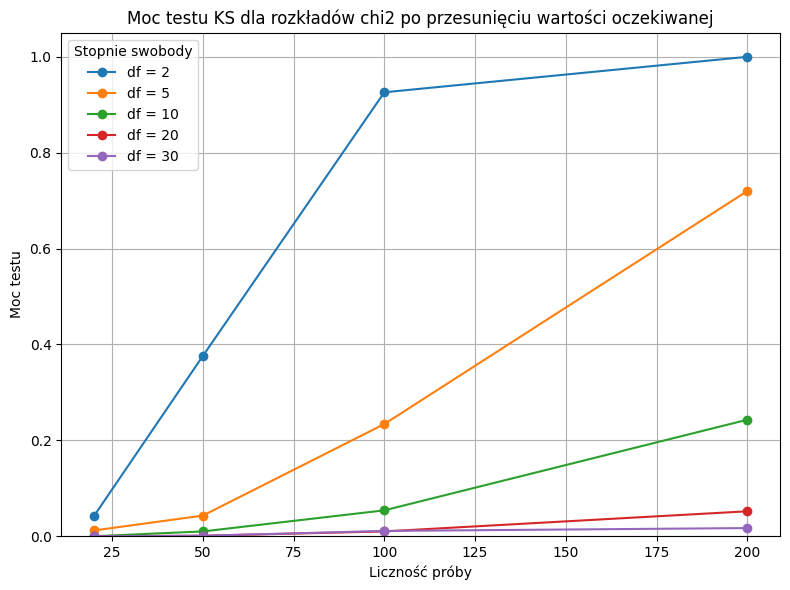

In [ ]:
# Parametry
sample_sizes = [20, 50, 100, 200]
degrees_of_freedom = [2, 5, 10, 20, 30]
n_simulations = 1000
alpha = 0.05

# Funkcja mocy dla testu KS po przesunięciu danych
def estimate_power_shifted(df_chi, n):
    rejections = 0
    for _ in range(n_simulations):
        sample = stats.chi2.rvs(df_chi, size=n)
        
        # Przesunięcie: wyrównanie wartości oczekiwanej do 0 (jak w N(0,1))
        shift = stats.norm.mean() - stats.chi2.mean(df_chi)
        sample_shifted = sample + shift
        
        # Test KS
        p_value = stats.kstest(sample_shifted, 'norm', args=(np.mean(sample_shifted), np.std(sample_shifted, ddof=1))).pvalue
        if p_value < alpha:
            rejections += 1
    return rejections / n_simulations


# Obliczanie mocy
power_matrix = []

for df_chi in degrees_of_freedom:
    row = []
    for n in sample_sizes:
        power = estimate_power_shifted(df_chi, n)
        row.append(power)
    power_matrix.append(row)

power_matrix = np.array(power_matrix)


# Wykres
plt.figure(figsize=(8,6))
for i, df_chi in enumerate(degrees_of_freedom):
    plt.plot(sample_sizes, power_matrix[i,:], marker='o', label=f'df = {df_chi}')
    
plt.title('Moc testu KS dla rozkładów chi2 po przesunięciu wartości oczekiwanej')
plt.xlabel('Liczność próby')
plt.ylabel('Moc testu')
plt.legend(title='Stopnie swobody')
plt.grid(True)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# WNIOSKI
# Moc testu KS zależy silnie od liczby stopni swobody chi2
# Im większe df tym mniejsza moc testu KS w wykrywaniu nienormalności po przesunięciu średniej.
# Dla df=2 test jest bardzo czuły (moc bliska 100% przy n≥100).
# Dla df=30 nawet przy dużych próbkach (n=200) moc testu KS jest bardzo mała (< 2.4%).

# Moc rośnie wraz z licznością próby
# Przy każdym df większa próbka pozwala testowi wykrywać nienormalność skuteczniej.
# Jednak efekt rośnie silniej dla małych df niż dla dużych df.

# Przesunięcie wartości oczekiwanej nie „ukrywa” nienormalności w rozkładach o małym df, ale przy dużych df rozkład chi2 staje się zbliżony do normalnego i test traci moc.

# Test KS jest bardzo czuły przy rozkładach silnie skośnych (df=2,5), ale praktycznie „ślepy” przy df=30 nawet dla dużych prób.


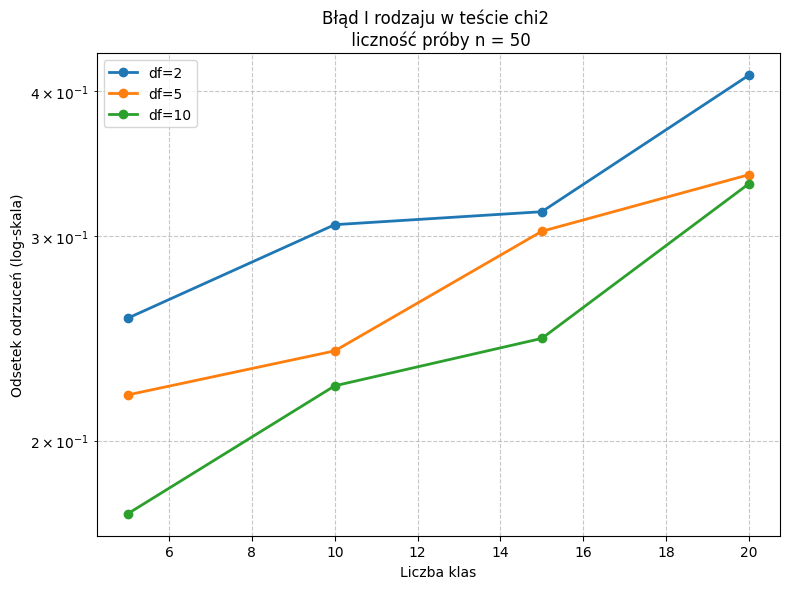

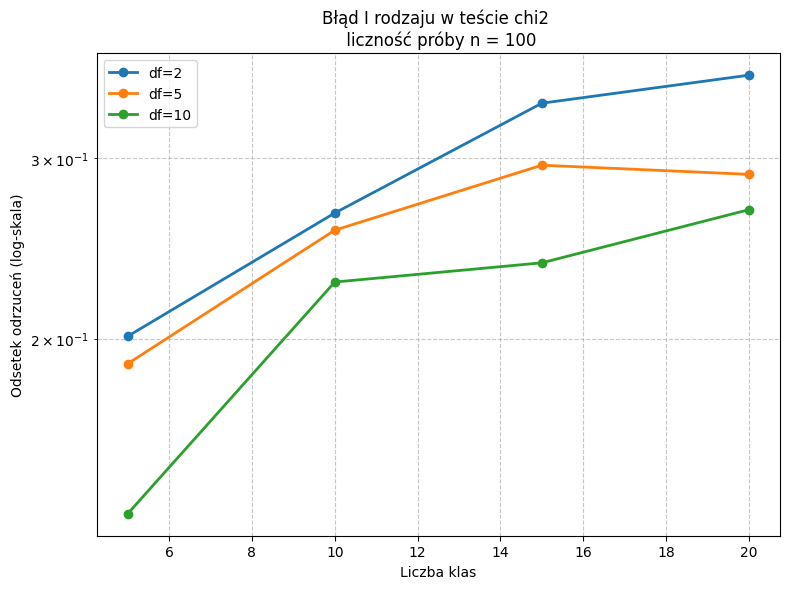

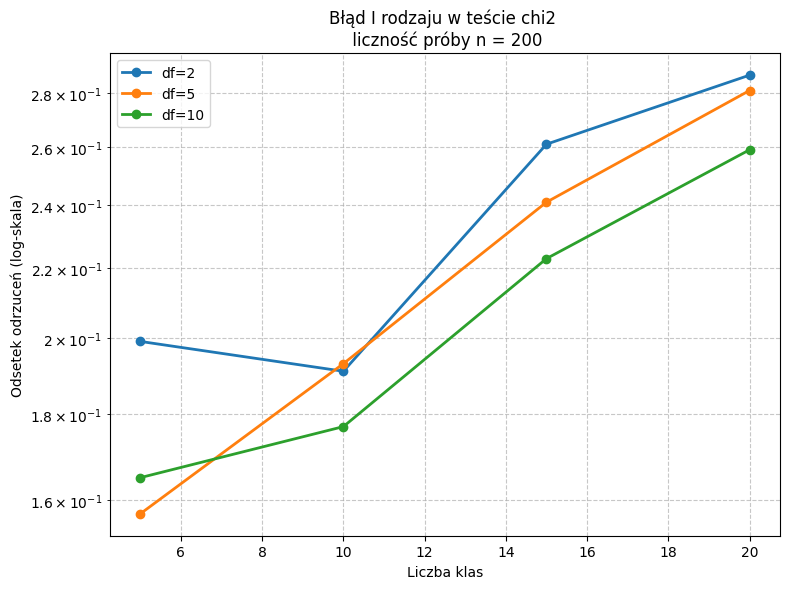

In [ ]:
# Parametry
sample_sizes = [50, 100, 200]
degrees_of_freedom = [2, 5, 10]
number_of_bins = [5, 10, 15, 20]
n_simulations = 500
alpha = 0.05

# Funkcja testu chi-kwadrat
def chi2_gof_test(sample, df, bins):
    observed, bin_edges = np.histogram(sample, bins=bins)
    cdf = stats.chi2.cdf(bin_edges, df)
    expected = len(sample) * np.diff(cdf)
    expected[expected < 1e-6] = 1e-6
    chi2_stat = ((observed - expected) ** 2 / expected).sum()
    df_chi2 = bins - 1 - 1
    p_value = 1 - stats.chi2.cdf(chi2_stat, df_chi2)
    return p_value

# Symulacje
results = {}

for n in sample_sizes:
    for df in degrees_of_freedom:
        power_per_bin = []
        for bins in number_of_bins:
            rejections = 0
            for _ in range(n_simulations):
                sample = stats.chi2.rvs(df, size=n)
                p_value = chi2_gof_test(sample, df, bins)
                if p_value < alpha:
                    rejections += 1
            power_per_bin.append(rejections / n_simulations)
        results[(n, df)] = power_per_bin

# Wykresy
for n in sample_sizes:
    plt.figure(figsize=(8,6))
    for df in degrees_of_freedom:
        y = np.array(results[(n, df)]) + 1e-3 
        plt.semilogy(number_of_bins, y, marker='o', markersize=6, label=f'df={df}', linewidth=2)
    plt.title(f'Błąd I rodzaju w teście chi2 \n liczność próby n = {n}')
    plt.xlabel('Liczba klas')
    plt.ylabel('Odsetek odrzuceń (log-skala)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# WNIOSKI
# Na każdym wykresie odsetek odrzuceń (błąd I rodzaju) rośnie wraz ze wzrostem liczby klas.
# Test chi2 staje się bardziej czuły na różnice w histogramie, gdy dzielimy dane na więcej przedziałów.
# Jednak duża liczba klas może powodować, że test niesłusznie zaczyna częściej odrzucać H0, nawet jeśli dane faktycznie pochodzą z rozkładu chi2 (co tutaj jest prawdą).